In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import scipy

# Загрузка и предобработка датасета

Мы заранее перемещаем кото-собак в одну папку для удобства 

In [2]:
catsAndDogs = os.listdir("./dataset/training_set/CatsAndDogs")
categories = []
for filename in catsAndDogs:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': catsAndDogs,
    'category': categories
})

In [3]:
df

,filename,category
0,cat.1014.jpg,0
1,dog.3505.jpg,1
2,dog.1138.jpg,1
3,dog.607.jpg,1
4,dog.3836.jpg,1
...,...,...
7995,dog.2262.jpg,1
7996,dog.1374.jpg,1
7997,cat.2315.jpg,0
7998,cat.1451.jpg,0


<AxesSubplot:>

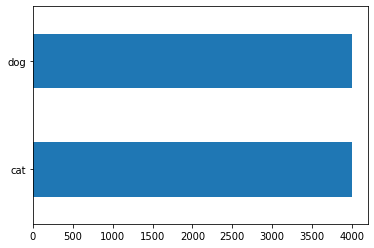

In [4]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
df['category'].value_counts().plot.barh()

Всего котособак у нас 8000, по 4000 в каждой категории

In [5]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

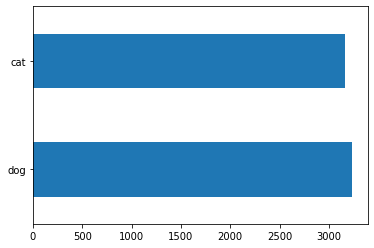

In [6]:
train_df['category'].value_counts().plot.barh()

<AxesSubplot:>

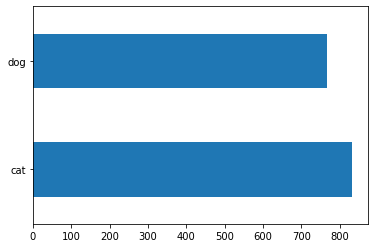

In [7]:
validate_df['category'].value_counts().plot.barh()

###  Тренировочный и проверочный генератор

In [8]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset/training_set/CatsAndDogs", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 6400 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset/training_set/CatsAndDogs", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.


## Модели

Модель 1

In [11]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(2, activation='relu')) # 2 because we have cat and dog classes

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 254018    
Total params: 255,042
Trainable params: 254,978
Non-trainable params: 64
_________________________________________________

In [12]:
epochs=7
history1 = model1.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/7
426/426 [==============================] - 189s 437ms/step - loss: nan - accuracy: 0.4943 - val_loss: nan - val_accuracy: 0.5201
Epoch 2/7
426/426 [==============================] - 107s 251ms/step - loss: nan - accuracy: 0.4951 - val_loss: nan - val_accuracy: 0.5208
Epoch 3/7
426/426 [==============================] - 110s 258ms/step - loss: nan - accuracy: 0.4954 - val_loss: nan - val_accuracy: 0.5195
Epoch 4/7
426/426 [==============================] - 95s 224ms/step - loss: nan - accuracy: 0.4946 - val_loss: nan - val_accuracy: 0.5189
Epoch 5/7
426/426 [==============================] - 69s 161ms/step - loss: nan - accuracy: 0.4949 - val_loss: nan - val_accuracy: 0.5208
Epoch 6/7
426/426 [==============================] - 76s 178ms/step - loss: nan - accuracy: 0.4951 - val_loss: nan - val_accuracy: 0.5208
Epoch 7/7
426/426 [==============================] - 77s 182ms/step - loss: nan - accuracy: 0.4954 - val_loss: nan - val_accuracy: 0.5176


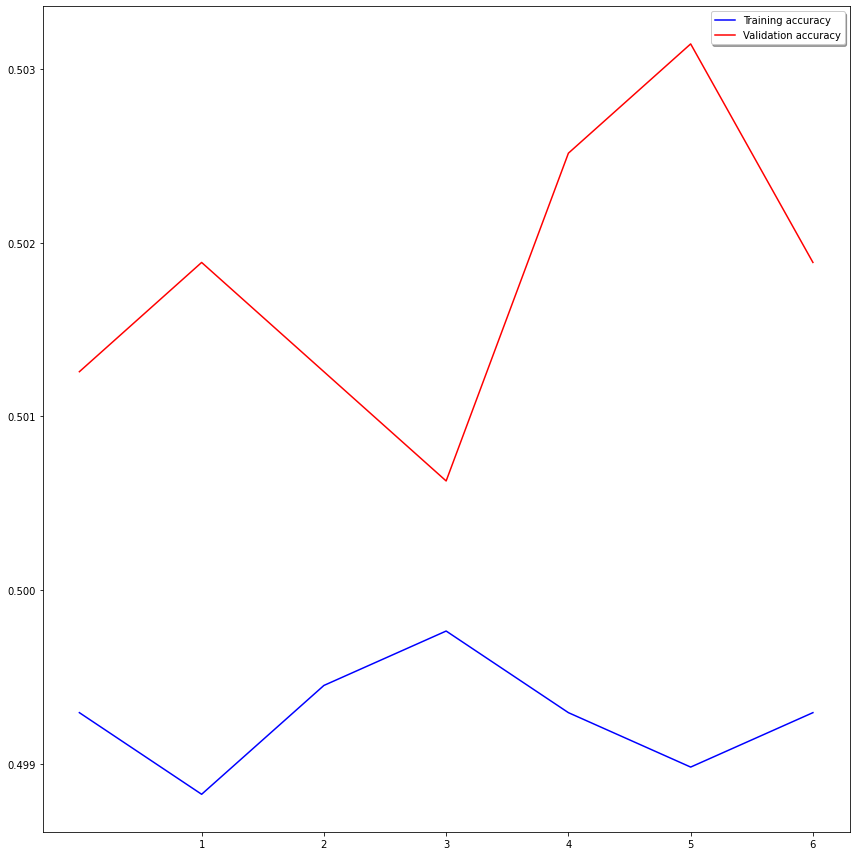

In [13]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

ax1.plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax1.plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
ax1.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Модель 3

In [21]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())

model3.add(Dense(2, activation='relu')) # 2 because we have cat and dog classes

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)       

In [22]:
epochs=7
history3 = model3.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/7
426/426 [==============================] - 146s 340ms/step - loss: nan - accuracy: 0.4946 - val_loss: nan - val_accuracy: 0.5189
Epoch 2/7
426/426 [==============================] - 155s 363ms/step - loss: nan - accuracy: 0.4948 - val_loss: nan - val_accuracy: 0.5214
Epoch 3/7
426/426 [==============================] - 156s 365ms/step - loss: nan - accuracy: 0.4954 - val_loss: nan - val_accuracy: 0.5189
Epoch 4/7
426/426 [==============================] - 155s 364ms/step - loss: nan - accuracy: 0.4949 - val_loss: nan - val_accuracy: 0.5208
Epoch 5/7
426/426 [==============================] - 155s 363ms/step - loss: nan - accuracy: 0.4948 - val_loss: nan - val_accuracy: 0.5208
Epoch 6/7
426/426 [==============================] - 155s 363ms/step - loss: nan - accuracy: 0.4951 - val_loss: nan - val_accuracy: 0.5201
Epoch 7/7
426/426 [==============================] - 155s 364ms/step - loss: nan - accuracy: 0.4944 - val_loss: nan - val_accuracy: 0.5214


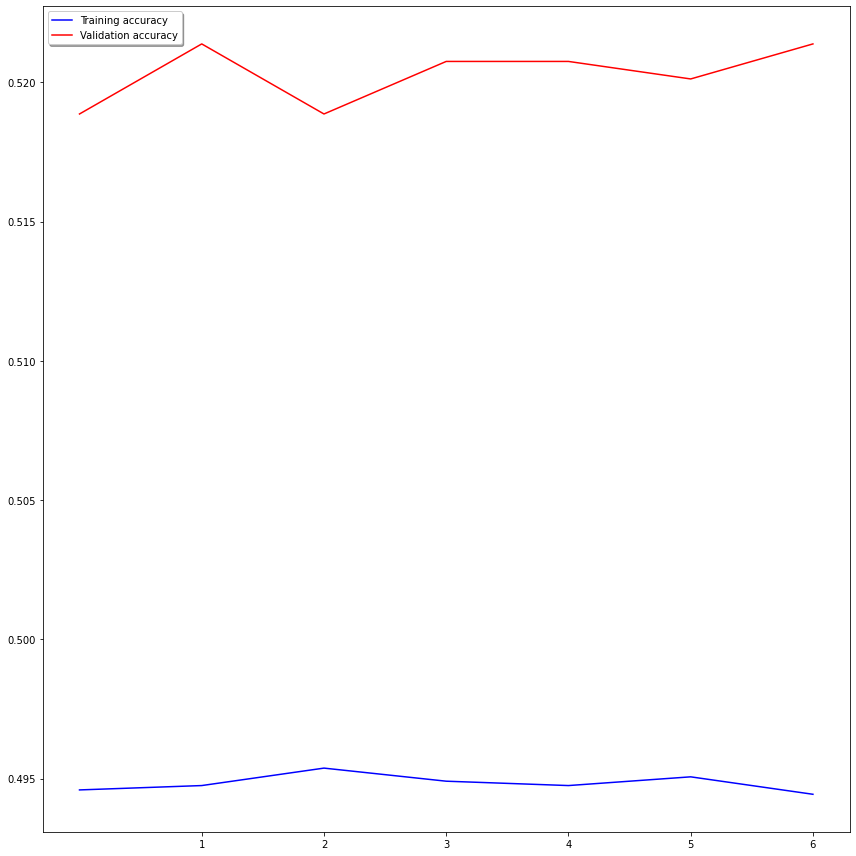

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

ax1.plot(history3.history['accuracy'], color='b', label="Training accuracy")
ax1.plot(history3.history['val_accuracy'], color='r',label="Validation accuracy")
ax1.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Модель 2

In [13]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(2, activation='relu')) # 2 because we have cat and dog classes

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [14]:
epochs=7
history2 = model2.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/7
426/426 [==============================] - 123s 288ms/step - loss: nan - accuracy: 0.4943 - val_loss: nan - val_accuracy: 0.5201
Epoch 2/7
426/426 [==============================] - 121s 283ms/step - loss: nan - accuracy: 0.4952 - val_loss: nan - val_accuracy: 0.5189
Epoch 3/7
426/426 [==============================] - 121s 284ms/step - loss: nan - accuracy: 0.4954 - val_loss: nan - val_accuracy: 0.5195
Epoch 4/7
426/426 [==============================] - 122s 286ms/step - loss: nan - accuracy: 0.4949 - val_loss: nan - val_accuracy: 0.5208
Epoch 5/7
426/426 [==============================] - 137s 322ms/step - loss: nan - accuracy: 0.4951 - val_loss: nan - val_accuracy: 0.5214
Epoch 6/7
426/426 [==============================] - 160s 376ms/step - loss: nan - accuracy: 0.4954 - val_loss: nan - val_accuracy: 0.5195
Epoch 7/7
426/426 [==============================] - 157s 368ms/step - loss: nan - accuracy: 0.4951 - val_loss: nan - val_accuracy: 0.5189


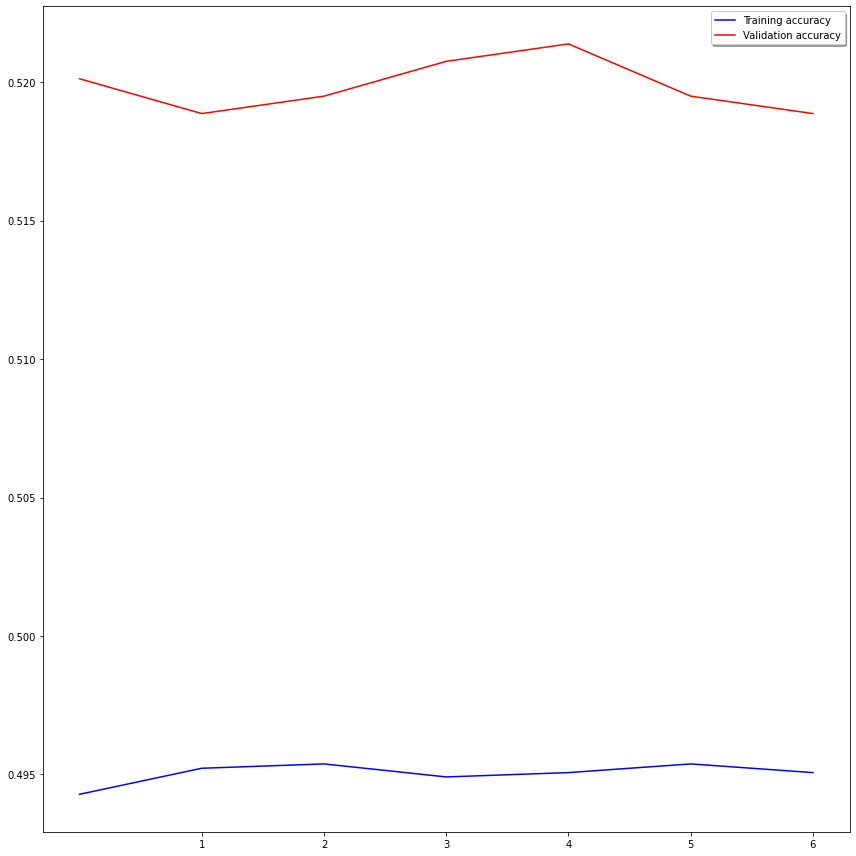

In [15]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

ax1.plot(history2.history['accuracy'], color='b', label="Training accuracy")
ax1.plot(history2.history['val_accuracy'], color='r',label="Validation accuracy")
ax1.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Модель 4

In [16]:
model4 = Sequential()

model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
model4.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

In [17]:
epochs=7
history4 = model4.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/7
426/426 [==============================] - 208s 484ms/step - loss: 0.9750 - accuracy: 0.5764 - val_loss: 0.6559 - val_accuracy: 0.6453
Epoch 2/7
426/426 [==============================] - 201s 471ms/step - loss: 0.6583 - accuracy: 0.6520 - val_loss: 0.5441 - val_accuracy: 0.7164
Epoch 3/7
426/426 [==============================] - 199s 468ms/step - loss: 0.6072 - accuracy: 0.6800 - val_loss: 0.5593 - val_accuracy: 0.7233
Epoch 4/7
426/426 [==============================] - 200s 469ms/step - loss: 0.5743 - accuracy: 0.7067 - val_loss: 0.8200 - val_accuracy: 0.6308
Epoch 5/7
426/426 [==============================] - 200s 470ms/step - loss: 0.5535 - accuracy: 0.7314 - val_loss: 0.4972 - val_accuracy: 0.7654
Epoch 6/7
426/426 [==============================] - 200s 470ms/step - loss: 0.5200 - accuracy: 0.7491 - val_loss: 1.6947 - val_accuracy: 0.5931
Epoch 7/7
426/426 [==============================] - 202s 473ms/step - loss: 0.5142 - accuracy: 0.7499 - val_loss: 0.9741 - val_ac

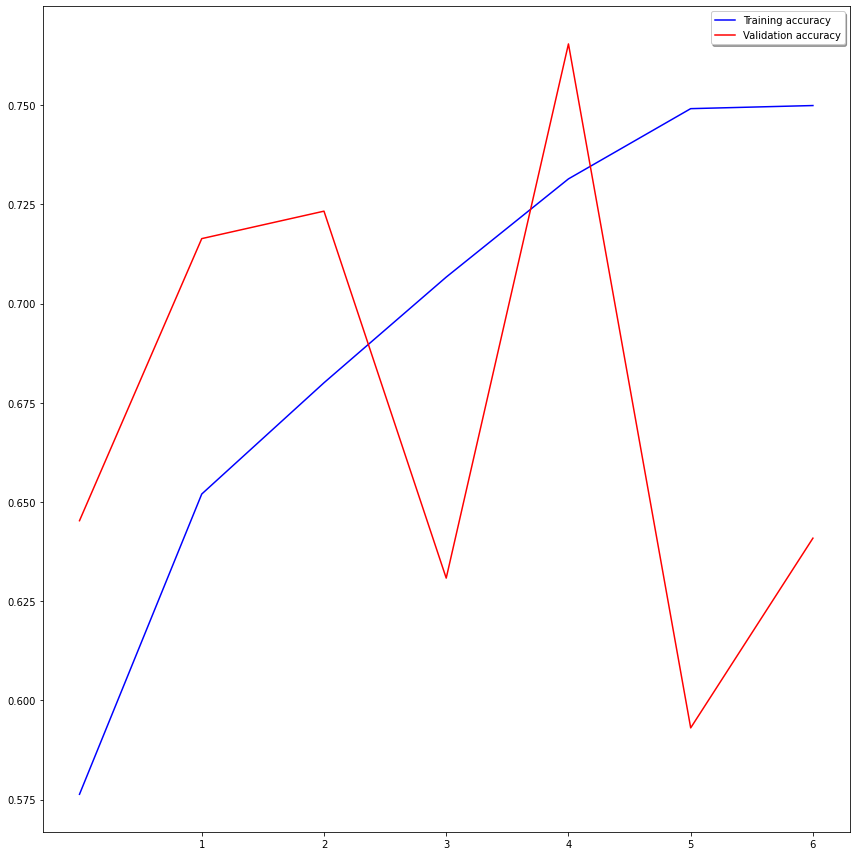

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

ax1.plot(history4.history['accuracy'], color='b', label="Training accuracy")
ax1.plot(history4.history['val_accuracy'], color='r',label="Validation accuracy")
ax1.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

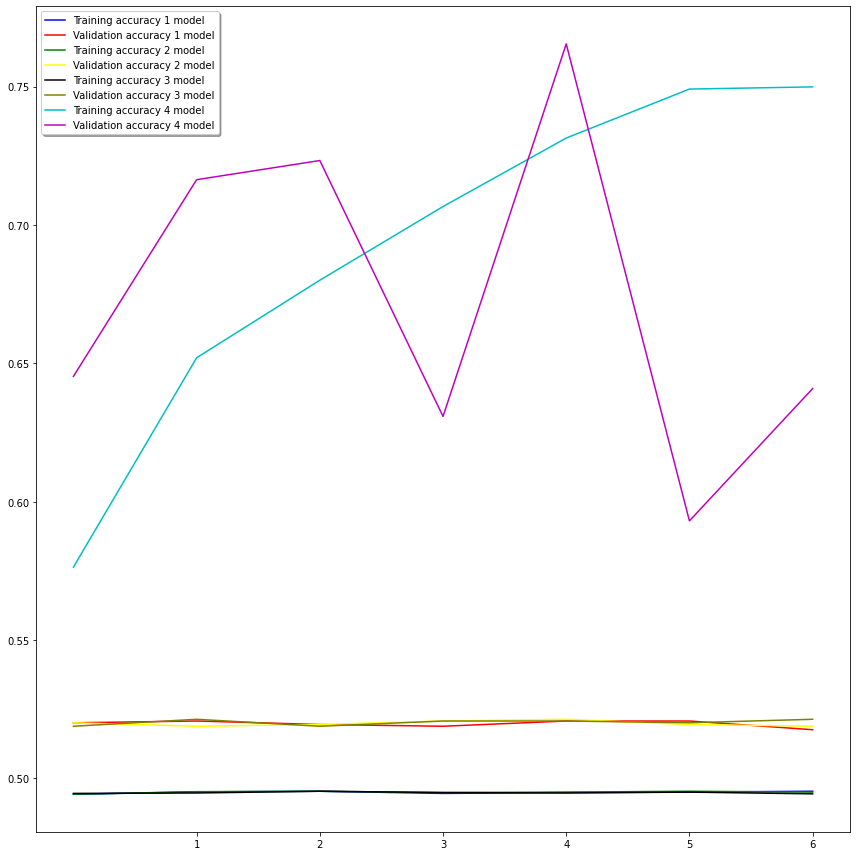

In [24]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

ax1.plot(history1.history['accuracy'], color='b', label="Training accuracy 1 model")
ax1.plot(history1.history['val_accuracy'], color='r',label="Validation accuracy 1 model")
ax1.plot(history2.history['accuracy'], color='g', label="Training accuracy 2 model")
ax1.plot(history2.history['val_accuracy'], color="yellow",label="Validation accuracy 2 model")
ax1.plot(history3.history['accuracy'], color='k', label="Training accuracy 3 model")
ax1.plot(history3.history['val_accuracy'], color="olive",label="Validation accuracy 3 model")
ax1.plot(history4.history['accuracy'], color='c', label="Training accuracy 4 model")
ax1.plot(history4.history['val_accuracy'], color='m',label="Validation accuracy 4 model")
ax1.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

При сравнении всех результатов на одном графике видно, что модель 4 показывает лучшую точность